## 機械学習フロー

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

## 【問題1】クロスバリデーション

In [2]:
df = pd.read_csv("application_train.csv")

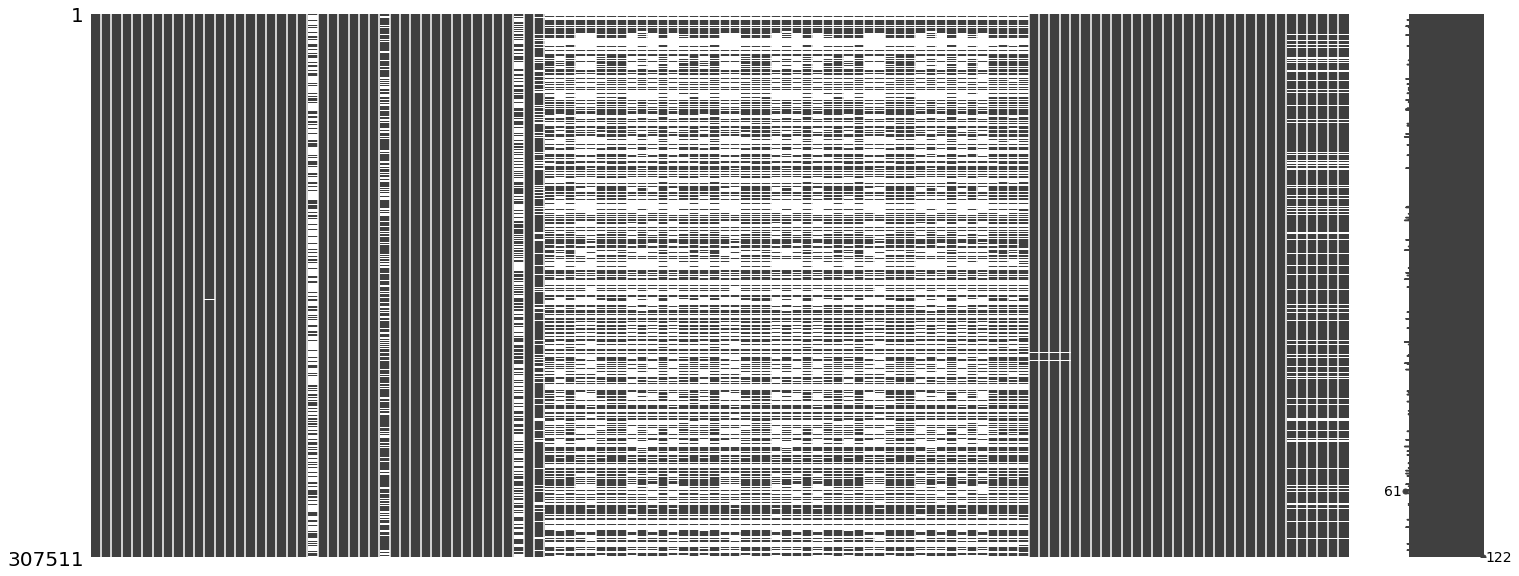

In [3]:
import missingno as msno
msno.matrix(df);

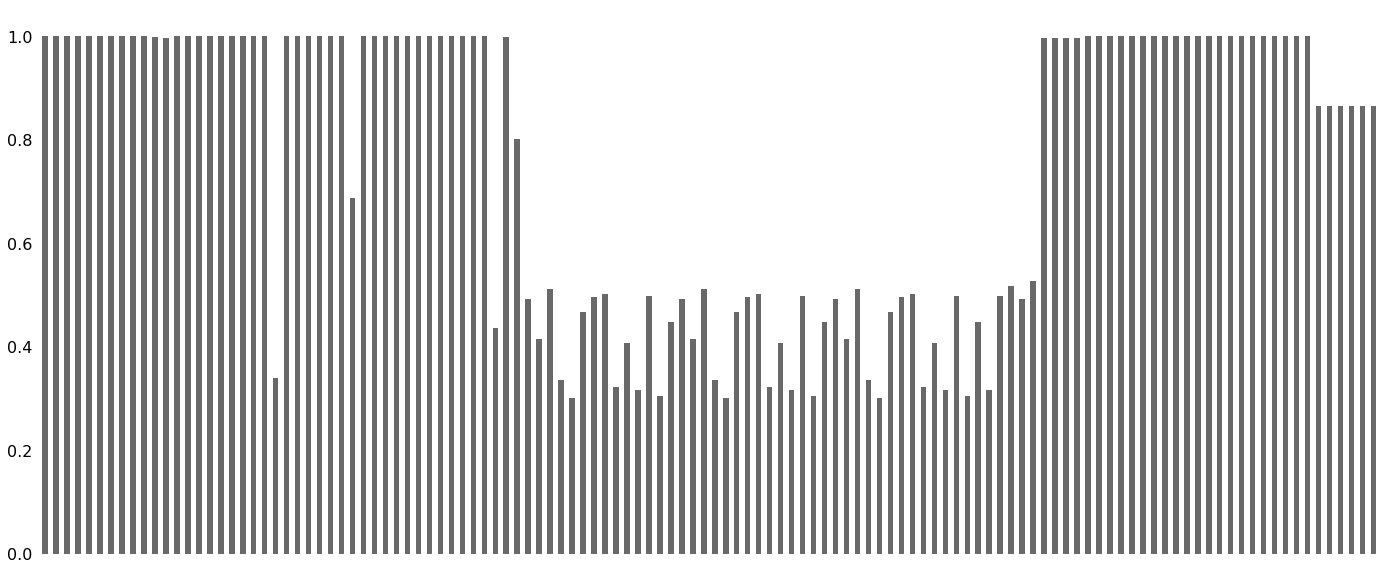

In [4]:
msno.bar(df);

In [5]:
df_s = np.abs(df.corr().loc[: , "TARGET"])
df_s.head()

SK_ID_CURR          0.002108
TARGET              1.000000
CNT_CHILDREN        0.019187
AMT_INCOME_TOTAL    0.003982
AMT_CREDIT          0.030369
Name: TARGET, dtype: float64

In [6]:
df_s = df_s.sort_values(ascending = False).head(11)

In [7]:
y = df.loc[: , "TARGET"]
x0 = df.loc[: , ["EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3" , "DAYS_BIRTH"]]
X1 = pd.concat([x0 , y] , axis = 1)
X1 = X1.dropna(how = "any")
X = X1.iloc[: , :4].values
y = X1.iloc[: , 4].values

In [8]:
#クロスバリデーション
from sklearn.model_selection import KFold
kf_5 = KFold(n_splits = 5 , random_state=None, shuffle=False)
kf_5.get_n_splits(X)
for train_index , test_index in kf_5.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train , X_test = X[train_index] , X[test_index]
    y_train , y_test = y[train_index] , y[test_index]

TRAIN: [ 21918  21919  21920 ... 109586 109587 109588] TEST: [    0     1     2 ... 21915 21916 21917]
TRAIN: [     0      1      2 ... 109586 109587 109588] TEST: [21918 21919 21920 ... 43833 43834 43835]
TRAIN: [     0      1      2 ... 109586 109587 109588] TEST: [43836 43837 43838 ... 65751 65752 65753]
TRAIN: [     0      1      2 ... 109586 109587 109588] TEST: [65754 65755 65756 ... 87669 87670 87671]
TRAIN: [    0     1     2 ... 87669 87670 87671] TEST: [ 87672  87673  87674 ... 109586 109587 109588]


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
lr = LogisticRegression()
lr.fit(X_train , y_train)
y_pred = lr.predict(X_test)
print(lr.score(X_test , y_test))
print(roc_auc_score(y_test , y_pred))

0.9278642149929278
0.5


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

knc = KNeighborsClassifier()
lr = LogisticRegression()
svc = SVC()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
from sklearn.model_selection import cross_val_score

models = []
models.append(("最近傍法" , knc))
models.append(("ロジスティック回帰" , lr))
#models.append(("SVM" , svc))
models.append(("決定木" , tree))
models.append(("ランダムフォレスト" ,  forest))

results = []
names = []
for name , model in models:
    result = cross_val_score(model , X_train , y_train , cv = kf_5  , scoring = "roc_auc")
    names.append(name)
    results.append(result)
    
for i in range(len(names)):
    print(names[i],results[i].mean())

最近傍法 0.535054784420565
ロジスティック回帰 0.5766310206465302
決定木 0.5379126426762669
ランダムフォレスト 0.6373451186825675


## 【問題2】グリッドサーチ

In [12]:
from sklearn.model_selection import GridSearchCV

#LogisticRegression(penalty="L1" or 'L2')
tree = RandomForestClassifier()
#parameters = {"C" : [0.1 , 1 , 10 , 100]}
parameters = {"n_estimators" : [50]}

clf = GridSearchCV(estimator = tree , param_grid = parameters , cv = kf_5 , scoring = "roc_auc")
clf.fit(X , y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [13]:
clf.best_score_

0.6890380789835412

In [14]:
clf.best_params_

{'n_estimators': 50}

## 【問題3】Kernelからの調査

In [15]:
#KaggleのKernelから様々なアイデアを見つけ出して、列挙してください。

・欠損値の補完

・別のツールの使用（LightGBM）

## 【問題4】高い汎化性能のモデル作成


## 欠損値を０に補完する

In [16]:
y = df.loc[: , "TARGET"]
x0 = df.loc[: , ["EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3" , "DAYS_BIRTH"]]
#from sklearn.preprocessing import Imputer
#imp = Imputer(strategy = "median" , axis = 0)
#imp.fit(x0)
#imp.transform(x0)

X1 = pd.concat([x0 , y] , axis = 1)
#X1 = X1.dropna(how = "any")
X = X1.iloc[: , :4]
y = X1.iloc[: , 4].values
X = X.fillna(0).values
#X = X.fillna(X.median()).values
#imp.fit(X)
#imp.transform(X)

In [17]:
from sklearn.model_selection import KFold
kf_5 = KFold(n_splits = 5 , random_state=None, shuffle=False)
kf_5.get_n_splits(X)
for train_index , test_index in kf_5.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train , X_test = X[train_index] , X[test_index]
    y_train , y_test = y[train_index] , y[test_index]

TRAIN: [ 61503  61504  61505 ... 307508 307509 307510] TEST: [    0     1     2 ... 61500 61501 61502]
TRAIN: [     0      1      2 ... 307508 307509 307510] TEST: [ 61503  61504  61505 ... 123002 123003 123004]
TRAIN: [     0      1      2 ... 307508 307509 307510] TEST: [123005 123006 123007 ... 184504 184505 184506]
TRAIN: [     0      1      2 ... 307508 307509 307510] TEST: [184507 184508 184509 ... 246006 246007 246008]
TRAIN: [     0      1      2 ... 246006 246007 246008] TEST: [246009 246010 246011 ... 307508 307509 307510]


In [18]:
models = []
models.append(("最近傍法" , knc))
models.append(("ロジスティック回帰" , lr))
#models.append(("SVM" , svc))
models.append(("決定木" , tree))
models.append(("ランダムフォレスト" ,  forest))

results = []
names = []
for name , model in models:
    result = cross_val_score(model , X_train , y_train , cv = kf_5  , scoring = "roc_auc")
    names.append(name)
    results.append(result)
    
for i in range(len(names)):
    print(names[i],results[i].mean())

最近傍法 0.5494870900069332
ロジスティック回帰 0.5826220515440108
決定木 0.6193616602861074
ランダムフォレスト 0.6189858953976191


## 欠損値を０に補完
## LightGBMを使用
## 特徴値をTARGETとの相関の高い上位１０使用

In [19]:
df_s

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
Name: TARGET, dtype: float64

In [20]:
X_1 = df.loc[: , ["EXT_SOURCE_3","EXT_SOURCE_2" , "EXT_SOURCE_1" , "DAYS_BIRTH" , 
                       "REGION_RATING_CLIENT_W_CITY" , "REGION_RATING_CLIENT" ,"DAYS_LAST_PHONE_CHANGE" , 
                         "DAYS_ID_PUBLISH" , "REG_CITY_NOT_WORK_CITY" , "FLAG_EMP_PHONE"]]
X_1 = X_1.fillna(0)

In [29]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=0)
lgb_train = lgb.Dataset(data = X_train , label = y_train)
lgb_test = lgb.Dataset(data = X_test , label = y_test)

In [30]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets = lgb_test , early_stopping_rounds = 150, verbose_eval = 200)

/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.728606
[400]	valid_0's auc: 0.731109
[600]	valid_0's auc: 0.731806
[800]	valid_0's auc: 0.731897
Early stopping, best iteration is:
[844]	valid_0's auc: 0.731901


In [1]:
#cross_val_score( lgb , X_train, y_train , cv = kf_5  , scoring = "roc_auc")

In [ ]:
lgb.plot_importance(model, figsize=(5, 5));

In [ ]:
from sklearn.model_selection import GridSearchCV

model = lgb.LGBMClassifier()
parameters = {"N_estimators" : [1 , 10 ,50 ,100 ] , "Max_depth" : [3 , 5 , 8]}

clf = GridSearchCV(estimator = model , param_grid = parameters , cv = kf_5 , scoring = "roc_auc")
clf.fit(X_1 , y)

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

## 欠損値を０に補完
## LightGBMを使用
## 特徴値をTARGETとの相関の高い上位4使用

In [ ]:
X = pd.DataFrame(X).fillna(0)
X.columns =["EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3" , "DAYS_BIRTH"]

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lgb_train = lgb.Dataset(data = X_train , label = y_train)
lgb_test = lgb.Dataset(data = X_test , label = y_test)

In [ ]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets = lgb_test , early_stopping_rounds = 150, verbose_eval= 200)
print(result = cross_val_score(model , X_train, y_train , cv = kf_5  , scoring = "roc_auc"))

In [ ]:
#lgb.plot_importance(model, figsize=(5, 5));

In [ ]:
from sklearn.model_selection import GridSearchCV

model = lgb.LGBMClassifier()
parameters = {"N_estimators" : [ 1 , 10 ,50 , 100] , "Max_depth" : [3 , 5 , 8]}

clf = GridSearchCV(estimator = model , param_grid = parameters , cv = kf_5 , scoring = "roc_auc")
clf.fit(X , y)

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

## 【問題5】最終的なモデルの選定